# Capstone project

## 1) A description of the problem and a discussion of the background.

### Introduction
When potential clients are going through real estate listings the only reference easily available is the average price in a given city or a district which is not always helpful because there are many factors to be considered when buying an apartment. I'm going to leverage information from Foursquare about a number of different types of venues nearby as well as information from local real estate listings website to predict prices of apartments and to identify which ones have most attractive price compared to the predicted price.
### Target audience
The final result may be of value for people who are looking to buy an apartment as well as people who are selling an apartment and would like to know what price to ask for.

## 2) A description of the data and how it will be used to solve the problem.

### There are two sources of the data which will be combined to solve the problem
#### City of choice
I'll analyze the city of Poznan in Poland, because this is where i live and therefore may one day need results of this project.
https://en.wikipedia.org/wiki/Pozna%C5%84
#### Foursquare data
I will identify what kind of venues are within a distance of each apartment. Next I'll count how many venues there are by category. I'll use this information in regression models to predict apartment prices.

Top level categories of Foursqare venue (based on https://developer.foursquare.com/docs/build-with-foursquare/categories/):
- Arts & Entertainment
- College & University
- Event
- Food
- Nightlife Spot
- Outdoors & Recreation
- Professional & Other Places
- Residence
- Shop & Service
- Travel & Transport

#### Data with real estate listings
I'll download all real estate listings in city of Poznan and use them in regression models to predict apartment prices. Types of data that I'm planning to use are 
- No of rooms
- Building type 
- Construction status 
- Price per m     
- Rent       
- Built year   
- Size
- Extras like lifts, garage etc.

#### Location data
To be able to explore venues around apartments, I'll also need location data. This information will be retrieved using OpenCage Geocoding API to get the longitude and latitude https://opencagedata.com/api#forward-opt
#### Only secondary market
There are significant differences between secondary and primary real estate market, therefore this project will focus only on secondary real estate market.

# Capstone project - week 5

#### Import necessary libraries

In [2]:
from bs4 import BeautifulSoup
import pandas as pd
import requests
import json
import re
import geopy
import seaborn as sns
import numpy as np
import urllib.request
import urllib.parse
import folium # map rendering library
from folium import plugins
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

 ## Page scraping the website with real estate listings

Website Has no API, so we need to write a parser to get the necessary information.
https://www.otodom.pl/

In [2]:
#Parse given url and construct BeautifulSoup object
def getSoupURL(url):
    r = None
    while (r is None):
        try:
            r  = requests.get(url)
        except:
            print("Failed to connect to {}".format(url))
    data = r.text
    return BeautifulSoup(data)

While using the website through browser, a user has to first enter a search query. \
To simplify things I've used filter on the website and copied search string below. \
We are loooking at apartments which are:
- in the **city of Poznan in Poland**
- from **secondary market** 

In [3]:
search_string = "https://www.otodom.pl/sprzedaz/mieszkanie/poznan/?search%5Bfilter_enum_market%5D=secondary&search%5Bregion_id%5D=15&search%5Bsubregion_id%5D=462&search%5Bcity_id%5D=1"

In [4]:
soup = getSoupURL(search_string)

#### Next, we need to go read a separate URL with details for each of them.

In [5]:
#But first we need to parse a number of result pages - because of pagination
soup_string = str(soup)
page_count_location = soup_string.find("page_count")
page_count_location += +len("page_count") + 3
page_count_string = soup_string[page_count_location:page_count_location + 4]
page_count = int(re.sub('\W+','', page_count_string ))

We want a full list of URLs leading to details about apartments for sale.

In [6]:
#Parse URLs from a single page
def getURLsfromSite(soup):
    tables = soup.find_all(["a"])
    res = []
    for a in tables:
        text = str(a)
        #offer URLs start with https://www.otodom.pl/oferta
        if text.find("https://www.otodom.pl/oferta/") > -1:
            #and contain #
            if "#" in str(a.get('href')):
                res.append(a.get('href'))
    res = list( dict.fromkeys(res) )
    return res

iterate through each page to get a combined list of URLs

In [7]:
postings_urls = []
for i in range(1, page_count+1):
    new_soup = getSoupURL(search_string + "&page=" + str(i))
    postings_urls.extend(getURLsfromSite(new_soup))

remove potential duplicates

In [8]:
postings_urls = list(dict.fromkeys(postings_urls))
print("We found {0} urls.".format(len(postings_urls)))

We found 2411 urls.


###  Next we want to visit each posting and parse the relevant information.

Each website contains information about specific appartmen. This is how parsed JSON data looks like when you check Source Code of the website. We are interested with apartments characteristics like : **Id, Number of Rooms, Price_per_m, Rent, Build_year, Size of the appartmen, Building_floors_num, Floor_no, Extras_types, district, address**
<code>
{'initialProps': {'meta': {'target': {
    'Build_year': '2014',
    'Building_floors_num': '4',
    'Building_material': ['silikat'],
    'Building_ownership': ['full_ownership'],
    'Building_type': ['block'],
    'Construction_status': ['ready_to_use'],
    'Country': 'Polska',
    'Extras_types': ['balcony',  'garage', 'lift', 'separate_kitchen', 'usable_room'],
    'Floor_no': ['floor_1'],
    'Id': '59963036',
    'MarketType': 'secondary',
    'Media_types': ['cable-television', 'internet', 'phone'],
    'Price': 420000,
    'Price_per_m': 7616,
    'Rent': 347,
    'Rooms_num': ['3']}</code>

A support method for parsing json only when given key exists

In [9]:
def parse_if_exist(json, key):
    if key in json["initialProps"]["meta"]["target"]:
        return json["initialProps"]["meta"]["target"][key]
    else:
        return None

A support method to get district name from location data

In [10]:
def parse_district_name(location):
    for level in location["geoLevel"]:
        if "district" in level["type"]:
            return level["label"]

### Download all listings

In [11]:
app_id = []
rooms = []
price_per_m = []
rent = []
built_year = []
size = [] 
floors = []
floor_no = []
extras = []
district = []
address = []
building_type = []
construction_status = [] 
urls = []
descriptions = []

In [14]:
for url in postings_urls:
    soup = getSoupURL(url)
    scripts = soup.find_all(['script'])
    for script in scripts:
        if script.get("id") == "server-app-state":
            script_text = str(script.text)
            details = json.loads(script_text)
            #print(url)
            #print("Found details like " + str(script_text)[0:2000])
            app_id.append(parse_if_exist(details, "Id"))
            rooms.append(parse_if_exist(details, "Rooms_num"))
            building_type.append(parse_if_exist(details, "Building_type"))
            construction_status.append(parse_if_exist(details, "Construction_status"))
            price_per_m.append(parse_if_exist(details, "Price_per_m"))
            rent.append(parse_if_exist(details, "Rent"))
            built_year.append(parse_if_exist(details, "Build_year"))
            size.append(parse_if_exist(details, "Area"))
            floors.append(parse_if_exist(details, "Building_floors_num"))
            floor_no.append(parse_if_exist(details, "Floor_no"))
            extras.append(parse_if_exist(details, "Extras_types"))
            location_details = details["initialProps"]["data"]["advert"]["location"]
            district.append(parse_district_name(location_details))
            address.append(location_details["address"])
            descriptions.append(details["initialProps"]["data"]["advert"]["description"])
            urls.append(url)

### Let's buid a data frame from parsed data and have a frist look at what was retrieved.

In [13]:
df = pd.DataFrame({"id": app_id, "rooms": rooms, "building_type": building_type,
                   "construction_status": construction_status, 
                   "price per m": price_per_m, "rent": rent, "built year": built_year, "size": size,
                   "floors": floors, "floor no": floor_no,
                  "extras": extras, "district": district, "address": address, "url": urls, "description": descriptions})
df.head(2)

,id,rooms,building_type,construction_status,price per m,rent,built year,size,floors,floor no,extras,district,address,url,description
0,60449395,[1],None,None,12344,NaN,None,32,None,None,"[balcony, garage, lift]",Rataje,"Poznań, Nowe Miasto, Rataje, ul. Katowicka 25",https://www.otodom.pl/oferta/luksusowa-kawaler...,"<p>Sprzedam bezpośrednio ekskluzywną, w pełni ..."
1,60575314,[4],[block],[ready_to_use],14000,900.0,2017,90,5,[floor_5],"[balcony, basement, garage, lift, usable_room]",Jeżyce,"Poznań, Jeżyce, ul. Kościelna",https://www.otodom.pl/oferta/jedyny-taki-apart...,<p><strong>WYJĄTKOWY APARTAMENT –</strong> NOW...


### Cleaning the data

We can easily correct values of:
- correct values in rooms
- correct values in building_type
- correct values in construction_status
- convert floor no to numerical values

In [15]:
df["rooms"] = df["rooms"].apply(lambda x: x[0])

In [16]:
df["building_type"] = df["building_type"].apply(lambda x: x[0] if x is not None else x)
df["construction_status"] = df["construction_status"].apply(lambda x: x[0] if x is not None else x)

In [17]:
def floor_no_to_int(x):
    if x is not None:
        if "ground_floor" == x[0]:
            return 0
        elif x[0] in ["cellar", 'garret']: 
            return -1
        else:
            return int(x[0][-1])
    else:
        return None

In [18]:
df["floor no"] = df["floor no"].apply(floor_no_to_int)

Just in case, create a backup data frame, because it takes some time to retrieve all listings.

In [19]:
df_backup_with_listings = df.copy()

Postings with missing districts are very poorly described and have little details about location, so lets remove them.

In [21]:
df = df[df["district"].notnull()]
df.reset_index(drop=True, inplace=True)

In [24]:
df.shape

(2348, 15)

Lets check if an how many missing values do we have to deal with. Missing values are not there because they were not provided by sellers.

In [25]:
df.isnull().sum()

id                        0
rooms                     0
building_type           395
construction_status     702
price per m               0
rent                   1062
built year              734
size                      0
floors                  121
floor no                 33
extras                  409
district                  0
address                   0
url                       0
description               0
dtype: int64

### Half of values for rent are missing. 
But we can see that there is a correlation between size of the appartment and the rent value. Let's built a linear regression model and replace missing rent values with predicted values.

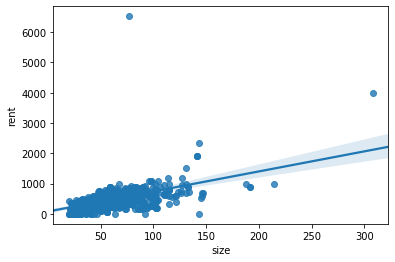

In [40]:
df_rent = df[df["rent"].notnull()].copy()
df_rent["rent"] = df_rent["rent"].astype(float)
df_rent["size"] = df_rent["size"].astype(float)
ax2 = sns.regplot(x="size", y='rent', data=df_rent)

In [41]:
X = df_rent[["size"]]
y = df_rent["rent"].values
from sklearn.linear_model import LinearRegression
reg = LinearRegression().fit(X, y)
R2_score = reg.score(X, y)
print("R2 score for linear regression is {}".format(R2_score))

R2 score for linear regression is 0.28686525519481276


In [42]:
df["size"] = df["size"].astype(float)
df["rent_hat"] = reg.predict(df[["size"]])

In [60]:
new_rent = []
for old_rent, rent_hat in zip(df["rent"], df["rent_hat"]):
    if pd.notna(old_rent):
        new_rent.append(old_rent)
    else:
        new_rent.append(rent_hat)
df["rent"] = new_rent

lets see what kind of values do we have in construction status

In [428]:
df["construction_status"].unique()

array([None, 'ready_to_use', 'to_renovation', 'to_completion'],
      dtype=object)

Lets replace this column with boolean columns

In [61]:
df["for_renovation"] = df["construction_status"].apply(lambda x: 1 if x in ['to_renovation'] else 0)
df["for_completion"] = df["construction_status"].apply(lambda x: 1 if x in ['to_completion'] else 0)
df.drop(["construction_status"], axis=1, inplace=True)

Lets take a closer look at built year and building type \
as there is about 25% of data missing lets replace them with mean.

In [68]:
df["built year"] = df["built year"].apply(lambda x: int(x) if x is not None else 0)
df["built year"] = df["built year"].astype(int)
mean_year = df[df["built year"] > 1850]["built year"].mean()
df["built year"] = df["built year"].apply(lambda x: x if x > 1850 else mean_year)

Next lets check building type

In [70]:
df[df["building_type"].notna()][["building_type", "built year"]].groupby("building_type").agg(['mean','count', 'min', 'max'])

built year                      
                      mean count     min     max
building_type                                   
apartment      2010.824003   306  1955.0  2022.0
block          1987.472845  1060  1914.0  2022.0
house          1969.039633    29  1912.0  2020.0
infill         2003.250000     4  1999.0  2010.0
loft           2018.000000     1  2018.0  2018.0
ribbon         1988.295356    11  1945.0  2012.0
tenement       1936.804080   542  1880.0  2020.0

Lets replace infill, loft with most numerous type block as there are only few of these values.

In [71]:
df["building_type"] = df["building_type"].apply(lambda x: None if x in ['infill', 'loft'] else x)

Check the boxplot for each building type separately to see if there visible differences in prices depending on building type

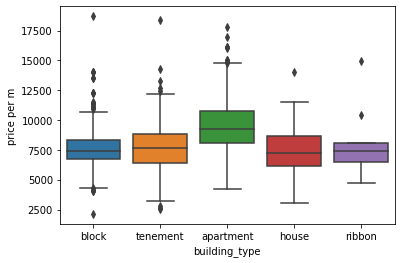

In [73]:
ax = sns.boxplot(x="building_type", y='price per m', data=df)

In [74]:
#remove appartments with a price per meter lower than 3000 and greater than 17000
df = df[df["price per m"] > 3000]
df = df[df["price per m"] < 17000]

### Convert Categorical features to numerical values

In [75]:
df['building_type'].replace(to_replace=['house', 'ribbon', 'apartment', 'tenement', 'block'], value=[0,1,2,3,4],inplace=True)

### And replace missing values with most numerous type 'block'

In [80]:
df['building_type'].fillna(value=4, inplace=True)

### Lets clean missing information about floors
by replacing missing floors and floor no values with average in the city and conver these columns to float.

In [76]:
floor_no_mean = df["floor no"].notnull().mean()
df["floor no"] = df["floor no"].apply(lambda x: x if pd.notna(x) else floor_no_mean)
floors_mean = df["floors"].notnull().mean()
df["floors"] = df["floors"].apply(lambda x: x if x is not None else floors_mean)

In [78]:
df.isnull().sum()

id                  0
rooms               0
building_type     399
price per m         0
rent                0
built year          0
size                0
floors              0
floor no            0
extras            406
district            0
address             0
url                 0
description         0
rent_hat            0
for_renovation      0
for_completion      0
dtype: int64

Next, we want to conver extras column to separate boolean columns

In [81]:
ext_dict = {"has_balcony": [], "has_basement": [],
                          "has_garage": [], "has_garden": [],
                          "has_terrace": [], "has_lift": [],
                          "is_two_storey": [] }

In [82]:
for ext in df["extras"]:
    has_balcony = 0
    has_basement = 0
    has_garage = 0
    has_garden = 0
    has_terrace = 0
    has_lift = 0
    is_two_storey = 0
    if ext is not None:
        for e in ext:
            if e == "balcony":
                has_balcony = 1
            elif e == "basement":
                has_basement = 1
            elif e == "garage":
                has_garage = 1
            elif e == "garden":
                has_garden = 1
            elif e == "terrace":
                has_terrace = 1
            elif e == "lift":
                has_lift =1
            elif e == "two_storey":
                is_two_storey = 1
    ext_dict["has_balcony"].append(has_balcony)
    ext_dict["has_basement"].append(has_basement)
    ext_dict["has_garage"].append(has_garage)
    ext_dict["has_garden"].append(has_garden)
    ext_dict["has_terrace"].append(has_terrace)
    ext_dict["has_lift"].append(has_lift)
    ext_dict["is_two_storey"].append(is_two_storey)

In [83]:
df_extras = pd.DataFrame(ext_dict)

In [85]:
df = pd.concat([df, df_extras], axis=1)

In [86]:
df.drop(["extras"], axis=1, inplace=True)

Next step is to retrieve lovation of each apartment based on address.

In [87]:
df.head(2)

,id,rooms,building_type,price per m,rent,built year,size,floors,floor no,district,address,url,description,rent_hat,for_renovation,for_completion,has_balcony,has_basement,has_garage,has_garden,has_terrace,has_lift,is_two_storey
0,60449395,1,4.0,12344.0,291.594142,1978.049782,32.0,0.948291,0.985897,Rataje,"Poznań, Nowe Miasto, Rataje, ul. Katowicka 25",https://www.otodom.pl/oferta/luksusowa-kawaler...,"<p>Sprzedam bezpośrednio ekskluzywną, w pełni ...",291.594142,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0
1,60575314,4,4.0,14000.0,900.000000,2017.000000,90.0,5,5.000000,Jeżyce,"Poznań, Jeżyce, ul. Kościelna",https://www.otodom.pl/oferta/jedyny-taki-apart...,<p><strong>WYJĄTKOWY APARTAMENT –</strong> NOW...,675.325612,0.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0


### find and remove potential duplicates by id

In [88]:
global_ids = []
def isDuplicate(id):
    if id in global_ids:
        return True
    else:
        global_ids.append(id)
        return False

df['is_duplicate'] = df['id'].apply(isDuplicate)
df = df[df['is_duplicate'] == False]

In [89]:
df.shape

(2081, 24)

**Using OpenCage Geocoding API** to get the longitude and latitude
https://opencagedata.com/api#forward-opt

In [92]:
geo_key='3e3cc12415d54fa598003cc257642df1'
latitude = []
longitude = []
for adr in df["address"]:
    adr = str(adr).replace('ul.', '')
    splt = adr.split(",")
    search_adr = '{}, {}'.format(splt[-1].strip(), splt[0])
    parsed_address = urllib.parse.quote(search_adr)
    download_url = 'https://api.opencagedata.com/geocode/v1/geojson?q={}&key={}'.format(parsed_address, geo_key)
    lat_lng_coords = None
    while(lat_lng_coords is None):
        try:
            with urllib.request.urlopen(download_url) as urlop:
                lat_lng_coords = json.loads(urlop.read().decode())
        except:
            print("{}|{}".format(search_adr, download_url))
    latitude.append(lat_lng_coords['features'][0]['geometry']['coordinates'][1])
    longitude.append(lat_lng_coords['features'][0]['geometry']['coordinates'][0])

In [93]:
df["latitude"] = latitude
df["longitude"] = longitude

### Get coordinates for the center of the city

In [11]:
geo_key='3e3cc12415d54fa598003cc257642df1'
parsed_address = urllib.parse.quote("Poznań")
download_url = 'https://api.opencagedata.com/geocode/v1/geojson?q={}&key={}'.format(parsed_address, geo_key)
with urllib.request.urlopen(download_url) as urlop:
    lat_lng_coords = json.loads(urlop.read().decode())
poz_lat = lat_lng_coords['features'][0]['geometry']['coordinates'][1]
poz_long = lat_lng_coords['features'][0]['geometry']['coordinates'][0]

### calculate distance to the city center
Based on location details we can calculate a distance from apartment to the city center.

In [54]:
from geopy import distance
def getDistance(apartment_geo):
    city_center = (poz_lat, poz_long)
    return geopy.distance.distance(city_center, apartment_geo).km

In [100]:
apartments_distance = []
for lat, long in zip(latitude, longitude):
        apartments_distance.append(getDistance((lat, long)))

df["distance"] = apartments_distance

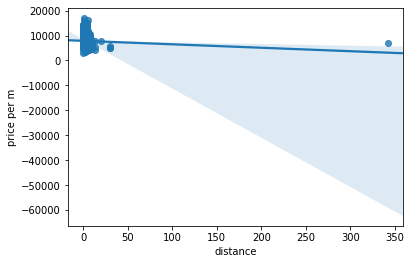

In [101]:
ax = sns.regplot(x="distance", y='price per m', data=df)

In [102]:
#remove appartments further than 9 km away from the city center
df = df[df["distance"] < 9]

In [5]:
#lets check what kid'a data types we have
df.dtypes

Unnamed: 0          int64
id                  int64
rooms               int64
building_type       int64
price per m         int64
rent              float64
built year        float64
size              float64
floors            float64
floor no          float64
district           object
address            object
url                object
description        object
rent_hat          float64
for_renovation      int64
for_completion      int64
has_balcony       float64
has_basement      float64
has_garage        float64
has_garden        float64
has_terrace       float64
has_lift          float64
is_two_storey     float64
is_duplicate         bool
latitude          float64
longitude         float64
distance          float64
dtype: object

We need to correct data types for:
- id
- rooms
- size
- floors

In [104]:
df["rooms"] = pd.to_numeric(df["rooms"], downcast='float', errors='coerce')
rooms_max = df["rooms"].max() 
df["rooms"] = df["rooms"].apply(lambda x: x if pd.notna(x) else rooms_max)

In [105]:
df["size"] = df["size"].astype(float)

In [106]:
df["floors"] = df["floors"].astype(float)

In [107]:
df["id"] = df["id"].astype(int)

### save backup to an Excel file

In [108]:
df.to_excel("otodom_poznan.xlsx")

In [40]:
df = pd.read_excel("otodom_poznan.xlsx", index_col=0)

### Identify and remove apartments with unclear legal status (based on description)

In [41]:
legal_unknown= []
for desc, url in zip(df["description"], df["url"]):
    if desc.lower().find("udzia") >= 0 and desc.lower().find("wskaza") >= 0:
        start = desc.lower().find("udzia")
        legal_unknown.append(True)
        #legal_unknown.append(desc[start:start + 100] + " " + url)
    else:
        legal_unknown.append(False)
df["legal unknown"] = legal_unknown
df = df[df["legal unknown"] == False]
df.drop(["legal unknown", "is_duplicate"], axis=1, inplace=True)

In [44]:
#and lets see description of the data
include =['object', 'float', 'int'] 
df.describe(include = include)

,rooms,building_type,price per m,rent,built year,size,floors,floor no,district,address,url,description,rent_hat,for_renovation,for_completion,has_balcony,has_basement,has_garage,has_garden,has_terrace,has_lift,is_two_storey,latitude,longitude,distance
count,2054.000000,2054.000000,2054.000000,2054.000000,2054.000000,2054.000000,2054.000000,2054.000000,2054,2054,2054,2054,2054.000000,2054.000000,2054.000000,2047.000000,2047.000000,2047.000000,2047.000000,2047.000000,2047.000000,2047.000000,2054.000000,2054.000000,2054.000000
unique,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,50,651,2054,1995,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Grunwald,"Poznań, Grunwald",https://www.otodom.pl/oferta/niesamowite-miesz...,<p>Polecam do sprzedaży mieszkanie w standardz...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,245,126,1,15,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,2.570107,3.445959,7845.778481,477.401615,1977.774906,59.888393,4.937524,2.184305,NaN,NaN,NaN,NaN,476.105421,0.067673,0.079357,0.462628,0.400586,0.239863,0.060088,0.072301,0.395213,0.018075,52.409562,16.918749,3.227986
std,1.065192,0.835029,1756.589816,287.183519,34.380925,32.658786,3.400085,1.931374,NaN,NaN,NaN,NaN,216.072482,0.251245,0.270362,0.498723,0.490137,0.427104,0.237708,0.259049,0.489016,0.133256,0.024385,0.031893,1.637174
min,1.000000,0.000000,3064.000000,1.000000,1880.000000,19.000000,0.948291,-1.000000,NaN,NaN,NaN,NaN,205.585364,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,52.341945,16.808681,0.000000
25%,2.000000,3.000000,6702.000000,350.000000,1976.000000,43.000000,3.000000,1.000000,NaN,NaN,NaN,NaN,364.370800,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,52.390130,16.898641,2.330681
50%,2.000000,4.000000,7638.000000,440.000000,1978.049782,52.830000,4.000000,2.000000,NaN,NaN,NaN,NaN,429.406668,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,52.404685,16.917438,3.053105
75%,3.000000,4.000000,8792.250000,550.000000,2008.000000,66.875000,5.000000,3.000000,NaN,NaN,NaN,NaN,522.329228,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,52.430926,16.938353,4.343205


In [45]:
df.head(2)

,rooms,building_type,price per m,rent,built year,size,floors,floor no,district,address,url,description,rent_hat,for_renovation,for_completion,has_balcony,has_basement,has_garage,has_garden,has_terrace,has_lift,is_two_storey,latitude,longitude,distance
id,,,,,,,,,,,,,,,,,,,,,,,,,
60449395,1,4,12344,291.594142,1978.049782,32.0,0.948291,0.985897,Rataje,"Poznań, Nowe Miasto, Rataje, ul. Katowicka 25",https://www.otodom.pl/oferta/luksusowa-kawaler...,"<p>Sprzedam bezpośrednio ekskluzywną, w pełni ...",291.594142,0,0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,52.399001,16.964067,2.320595
60575314,4,4,14000,900.000000,2017.000000,90.0,5.000000,5.000000,Jeżyce,"Poznań, Jeżyce, ul. Kościelna",https://www.otodom.pl/oferta/jedyny-taki-apart...,<p><strong>WYJĄTKOWY APARTAMENT –</strong> NOW...,675.325612,0,0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,52.417841,16.907349,2.075196


### Visualize the data on the city map

To make it faster lets use only 20% of data 

In [9]:
df_map = df[::5]

In [12]:
map_poznan = folium.Map(location=[poz_lat, poz_long], zoom_start=12)

#instantiate a mark cluster object for the postings in the dataframe
apartments_cluster = plugins.MarkerCluster().add_to(map_poznan)

# add markers to map
for lat, lng, address in zip(df['latitude'], df['longitude'], df_map['address']):
    label = '{}, {}, {}'.format(address, lat, lng)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(apartments_cluster)  
    
map_poznan

## Next, utilizing the Foursquare API, explore the surroundings of each appartment

Define Foursquare Credentials and Version

In [13]:
# @hidden_cell
CLIENT_ID = 'WCU4DFKQSFBVCJTZEXZ0KGSXIMZNKB4L2PIKD2WQ0AY2DJ21' # your Foursquare ID
CLIENT_SECRET = 'REPQCFDXZFCKTUSRGOTXWJYE3U02L2UTSABPOJ4F4DXY05CN' # your Foursquare Secret
VERSION = '20200616' # Foursquare API version

## Now we want to add infromation from Forsquare

### List of Foursquare categories to be able to group the results

In [48]:
url = "https://api.foursquare.com/v2/venues/categories?&client_id={}&client_secret={}&v={}".format(CLIENT_ID, CLIENT_SECRET, VERSION)
#requests.get(url).json()
all_categories = requests.get(url).json()["response"]['categories']

### read a list of top level categories and build a map of all children categories and parents

In [49]:
parent_categories = []
all_children_categories = {}

def getchildrencategories(categories, parent):
    for category in categories:
        if category["name"] not in all_children_categories:
            all_children_categories[category["name"]]=parent
            getchildrencategories(category["categories"], parent)

In [50]:
print("Top level categories:")
for category in all_categories:
    print("- {}".format(category["name"]))
    if category["name"] not in parent_categories:
        parent_categories.append(category["name"])
        getchildrencategories(category["categories"], category["name"])

Top level categories:
- Arts & Entertainment
- College & University
- Event
- Food
- Nightlife Spot
- Outdoors & Recreation
- Professional & Other Places
- Residence
- Shop & Service
- Travel & Transport


### Create a function to get name, location and categories of venues in a radius of 1000 meters from the coordinates of each apartment

In [51]:
def getCategory(category):
    if category in parent_categories:
        return category
    elif category in all_children_categories:
        return all_children_categories[category]
    else:
        print("Category not found for {}.".format(category))
        return "Residence"

In [52]:
def getNearbyVenues(latitude, longitude):
    venues_list=[]
    radius = 1000
    LIMIT = 150
    venues_list=[]
    # create the API request URL
    url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            latitude, 
            longitude, 
            radius, 
            LIMIT)
    # make the GET request
    results = None
    while(results is None):
        try:
            results = requests.get(url).json()["response"]['groups'][0]['items']
        except:
            print("Foursquare API failure at {}|{}|{} retrying..".format(latitude, longitude, url))
            
    
    for v in results:
        venues_list.append([
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            getCategory(v['venue']['categories'][0]['name'])])
    return venues_list

### Run the function for all coordinates for each apartment

In [55]:
venues = {}
for category in parent_categories:
    venues[category] = []
    
venues_distinct = {}
# iterate through all coordinates
for latitude, longitude in zip(df["latitude"], df["longitude"]):
    #dictionary to count a number of venues of a given category nearby apartment
    categories_counter = {}
    for category in parent_categories:
        categories_counter[category] = 0
    
    #try to find nearby apartments and get copy the same list of venues
    #to limit the number of calls to foursquare API
    nearby_distance = 0.05 #50 meters
    found_nearby = False
    for geo_key in venues_distinct:
        if geopy.distance.distance((latitude, longitude), geo_key).km <= nearby_distance:
            categories_counter = venues_distinct[geo_key]
            found_nearby = True        
    #if nearby apartments do not exists or were not explored yet
    if found_nearby == False:
        #get the list of venues from foursqare
        venues_list = getNearbyVenues(latitude, longitude)
        #count how many venues of each category exists nearby
        for venue in venues_list:
            categories_counter[venue[5]] += 1
        venues_distinct[(latitude, longitude)] = categories_counter
    for category in parent_categories:
        venues[category].append(categories_counter[category])

Foursquare API failure at 52.4152049|16.919472|https://api.foursquare.com/v2/venues/explore?&client_id=WCU4DFKQSFBVCJTZEXZ0KGSXIMZNKB4L2PIKD2WQ0AY2DJ21&client_secret=REPQCFDXZFCKTUSRGOTXWJYE3U02L2UTSABPOJ4F4DXY05CN&v=20200616&ll=52.4152049,16.919472&radius=1000&limit=150 retrying..
Foursquare API failure at 52.4022998|16.9306378|https://api.foursquare.com/v2/venues/explore?&client_id=WCU4DFKQSFBVCJTZEXZ0KGSXIMZNKB4L2PIKD2WQ0AY2DJ21&client_secret=REPQCFDXZFCKTUSRGOTXWJYE3U02L2UTSABPOJ4F4DXY05CN&v=20200616&ll=52.4022998,16.9306378&radius=1000&limit=150 retrying..


### Create a DataFrame from results and combine it with the main DataFrame


In [71]:
df_foursquare_api_data = pd.DataFrame(venues)
include =['object', 'float', 'int'] 
df_foursquare_api_data.describe(include = include)

,Arts & Entertainment,College & University,Event,Food,Nightlife Spot,Outdoors & Recreation,Professional & Other Places,Residence,Shop & Service,Travel & Transport
count,2054.000000,2054.000000,2054.0,2054.000000,2054.000000,2054.000000,2054.000000,2054.000000,2054.000000,2054.000000
mean,2.014119,0.035054,0.0,17.554528,2.630964,3.364654,0.219085,0.007790,7.310613,6.282376
std,2.575749,0.204046,0.0,19.267434,4.926457,2.105345,0.574423,0.087936,4.915250,3.257441
min,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.0,3.000000,0.000000,2.000000,0.000000,0.000000,4.000000,4.000000
50%,1.000000,0.000000,0.0,9.000000,0.000000,3.000000,0.000000,0.000000,6.000000,6.000000
75%,3.000000,0.000000,0.0,26.000000,3.000000,5.000000,0.000000,0.000000,9.000000,9.000000
max,11.000000,2.000000,0.0,67.000000,20.000000,16.000000,3.000000,1.000000,24.000000,17.000000


In [74]:
df_foursquare_api_data.head(2)

,Arts & Entertainment,College & University,Event,Food,Nightlife Spot,Outdoors & Recreation,Professional & Other Places,Residence,Shop & Service,Travel & Transport
0,4,0,0,20,0,7,0,0,9,2
1,4,0,0,43,2,6,0,0,10,8


In [95]:
df_copy_now = df.copy()
df_foursquare_api_data.columns.values

array(['Arts & Entertainment', 'College & University', 'Event', 'Food',
       'Nightlife Spot', 'Outdoors & Recreation',
       'Professional & Other Places', 'Residence', 'Shop & Service',
       'Travel & Transport'], dtype=object)

In [96]:
for category in df_foursquare_api_data.columns.values:
    df[category] = df_foursquare_api_data[category]

### We can remove Residence column as on average only 0.7% apartments have residence nearby; and Event as it has 0 values.

In [98]:
df.drop(["Residence"], axis=1, inplace=True)

In [99]:
df.drop(["Event"], axis=1, inplace=True)

Backup the data frame

In [100]:
df.to_excel("otodom_poznan_with_foursquare.xlsx")

In [3]:
df = pd.read_excel("otodom_poznan_with_foursquare.xlsx", index_col=0)

In [25]:
columns = df.columns
list(columns)

['id',
 'rooms',
 'building_type',
 'price per m',
 'rent',
 'built year',
 'size',
 'floors',
 'floor no',
 'district',
 'address',
 'url',
 'description',
 'rent_hat',
 'for_renovation',
 'for_completion',
 'has_balcony',
 'has_basement',
 'has_garage',
 'has_garden',
 'has_terrace',
 'has_lift',
 'is_two_storey',
 'latitude',
 'longitude',
 'distance',
 'Arts & Entertainment',
 'College & University',
 'Food',
 'Nightlife Spot',
 'Outdoors & Recreation',
 'Professional & Other Places',
 'Shop & Service',
 'Travel & Transport']

In [5]:
use_columns = ['rooms', 'building_type', 'rent', 'built year', 'size',
       'floors', 'floor no', 'for_renovation', 'for_completion', 'has_balcony',
       'has_basement', 'has_garage', 'has_garden', 'has_terrace', 'has_lift',
       'is_two_storey', 'distance',
       'Arts & Entertainment', 'College & University', 'Food',
       'Nightlife Spot', 'Outdoors & Recreation',
       'Professional & Other Places', 'Shop & Service', 'Travel & Transport']

In [6]:
df[use_columns].head()

,rooms,building_type,rent,built year,size,floors,floor no,for_renovation,for_completion,has_balcony,has_basement,has_garage,has_garden,has_terrace,has_lift,is_two_storey,distance,Arts & Entertainment,College & University,Food,Nightlife Spot,Outdoors & Recreation,Professional & Other Places,Shop & Service,Travel & Transport
0,1,4,291.594142,1978.049782,32.0,0.948291,0.985897,0,0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,2.320595,4,0,20,0,7,0,9,2
1,4,4,900.000000,2017.000000,90.0,5.000000,5.000000,0,0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,2.075196,4,0,43,2,6,0,10,8
2,3,3,628.351587,1950.000000,82.9,4.000000,3.000000,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.330681,0,0,9,1,5,0,7,6
3,2,4,350.000000,2015.000000,50.6,6.000000,2.000000,0,0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,4.974050,0,0,5,0,4,0,9,9
4,2,4,408.698401,1978.049782,49.7,0.948291,3.000000,0,0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,4.343205,4,0,17,0,2,0,22,10


In [7]:
df[use_columns].isnull().sum()

rooms                          0
building_type                  0
rent                           0
built year                     0
size                           0
floors                         0
floor no                       0
for_renovation                 0
for_completion                 0
has_balcony                    7
has_basement                   7
has_garage                     7
has_garden                     7
has_terrace                    7
has_lift                       7
is_two_storey                  7
distance                       0
Arts & Entertainment           0
College & University           0
Food                           0
Nightlife Spot                 0
Outdoors & Recreation          0
Professional & Other Places    0
Shop & Service                 0
Travel & Transport             0
dtype: int64

In [8]:
#replace missing data with 0 - in case if there were no venues at all
df.fillna(0, inplace=True)

In [9]:
include =['object', 'float', 'int'] 
df[use_columns].describe(include = include)

,rooms,building_type,rent,built year,size,floors,floor no,for_renovation,for_completion,has_balcony,has_basement,has_garage,has_garden,has_terrace,has_lift,is_two_storey,distance,Arts & Entertainment,College & University,Food,Nightlife Spot,Outdoors & Recreation,Professional & Other Places,Shop & Service,Travel & Transport
count,2054.000000,2054.000000,2054.000000,2054.000000,2054.000000,2054.000000,2054.000000,2054.000000,2054.000000,2054.000000,2054.000000,2054.000000,2054.000000,2054.000000,2054.000000,2054.000000,2054.000000,2054.000000,2054.000000,2054.000000,2054.000000,2054.000000,2054.000000,2054.000000,2054.000000
mean,2.570107,3.445959,477.401615,1977.774906,59.888393,4.937524,2.184305,0.067673,0.079357,0.461052,0.399221,0.239046,0.059883,0.072055,0.393866,0.018014,3.227986,2.014119,0.035054,17.554528,2.630964,3.364654,0.219085,7.310613,6.282376
std,1.065192,0.835029,287.183519,34.380925,32.658786,3.400085,1.931374,0.251245,0.270362,0.498602,0.489858,0.426605,0.237328,0.258641,0.488725,0.133033,1.637174,2.575749,0.204046,19.267434,4.926457,2.105345,0.574423,4.915250,3.257441
min,1.000000,0.000000,1.000000,1880.000000,19.000000,0.948291,-1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2.000000,3.000000,350.000000,1976.000000,43.000000,3.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.330681,0.000000,0.000000,3.000000,0.000000,2.000000,0.000000,4.000000,4.000000
50%,2.000000,4.000000,440.000000,1978.049782,52.830000,4.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.053105,1.000000,0.000000,9.000000,0.000000,3.000000,0.000000,6.000000,6.000000
75%,3.000000,4.000000,550.000000,2008.000000,66.875000,5.000000,3.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,4.343205,3.000000,0.000000,26.000000,3.000000,5.000000,0.000000,9.000000,9.000000
max,10.000000,4.000000,6522.000000,2023.000000,583.730000,61.000000,9.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,8.977678,11.000000,2.000000,67.000000,20.000000,16.000000,3.000000,24.000000,17.000000


## Predicting price of apparment - Using regression models

# Methodology 
section which represents the main component of the report where you discuss and describe any exploratory data analysis that you did, any inferential statistical testing that you performed, if any, and what machine learnings were used and why.

### exploratory data analysis

In [12]:
zero_one_columns = ['for_renovation', 'for_completion', 'has_balcony',
       'has_basement', 'has_garage', 'has_garden', 'has_terrace', 'has_lift',
       'is_two_storey']

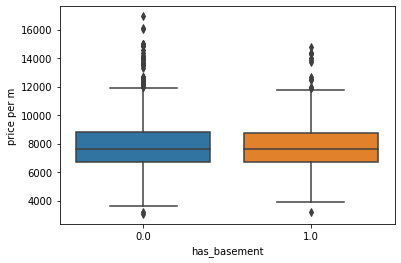

In [29]:
ax = sns.boxplot(x='has_basement', y='price per m', data=df)

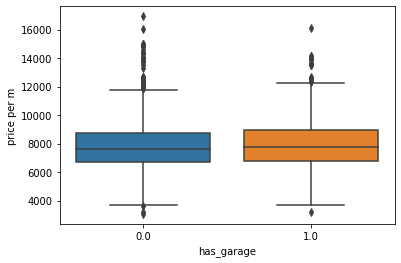

In [30]:
ax = sns.boxplot(x='has_garage', y='price per m', data=df)

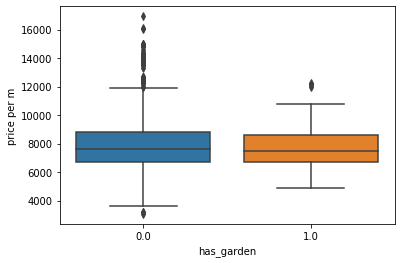

In [31]:
ax = sns.boxplot(x='has_garden', y='price per m', data=df)

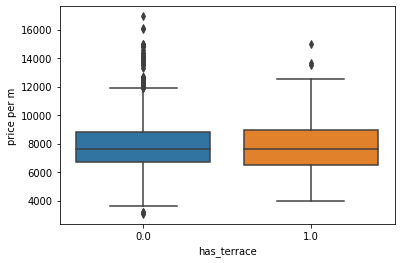

In [32]:
ax = sns.boxplot(x='has_terrace', y='price per m', data=df)

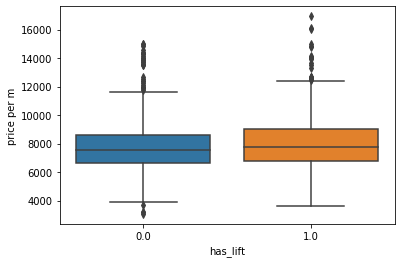

In [33]:
ax = sns.boxplot(x='has_lift', y='price per m', data=df)

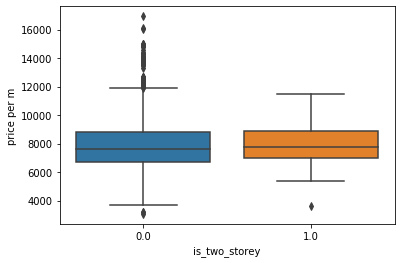

In [34]:
ax = sns.boxplot(x='is_two_storey', y='price per m', data=df)

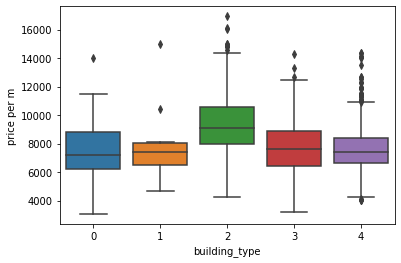

In [36]:
ax = sns.boxplot(x='building_type', y='price per m', data=df)

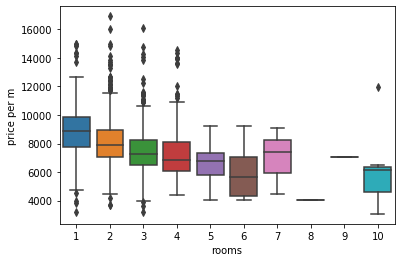

In [55]:
ax = sns.boxplot(x="rooms", y='price per m', data=df)

In [35]:
df.drop(['has_balcony', 'has_basement', 'has_garage', 'has_garden', 'has_terrace', 
         'has_lift','is_two_storey'], axis = 1, inplace=True)

In [ ]:
use_columns = ['rooms', 'building_type', 'rent', 'built year', 'size',
       'floors', 'floor no', 'distance',
       'Arts & Entertainment', 'College & University', 'Food',
       'Nightlife Spot', 'Outdoors & Recreation',
       'Professional & Other Places', 'Shop & Service', 'Travel & Transport']

In [58]:
df["rent"] = df["rent"].apply(lambda x: 1000 if x > 1000 else x)

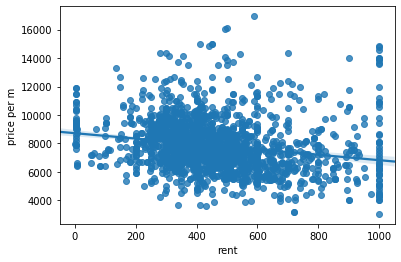

In [59]:
ax = sns.regplot(x="rent", y='price per m', data=df)

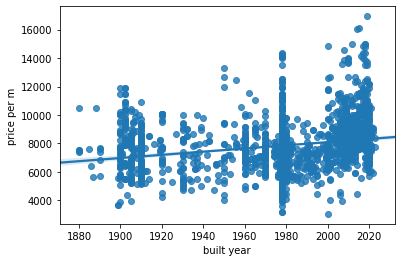

In [47]:
ax = sns.regplot(x="built year", y='price per m', data=df)

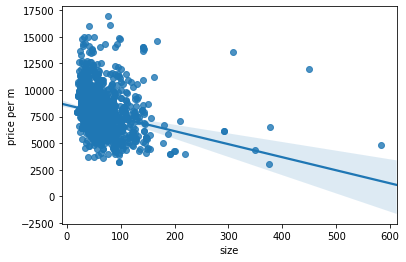

In [48]:
ax = sns.regplot(x="size", y='price per m', data=df)

In [65]:
df = df[df["size"] < 200].copy()

In [66]:
df["floors"] = df["floors"].apply(lambda x: x if x < 20 else 15).copy()

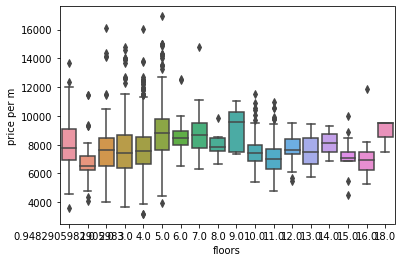

In [69]:
ax = sns.boxplot(x="floors", y='price per m', data=df)

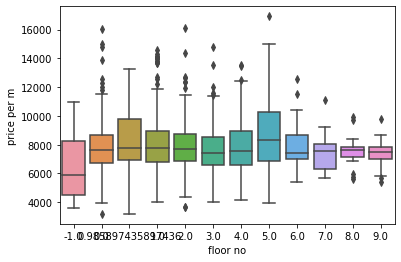

In [70]:
ax = sns.boxplot(x="floor no", y='price per m', data=df)

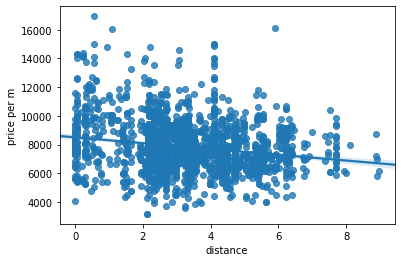

In [71]:
ax = sns.regplot(x="distance", y='price per m', data=df)

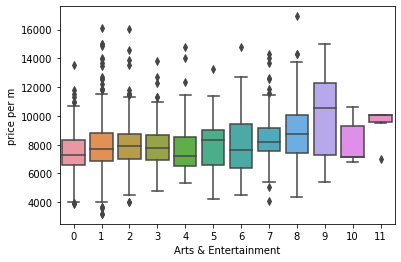

In [72]:
ax = sns.boxplot(x="Arts & Entertainment", y='price per m', data=df)

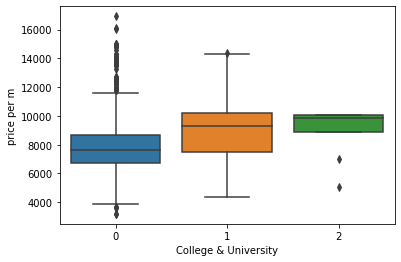

In [73]:
ax = sns.boxplot(x="College & University", y='price per m', data=df)

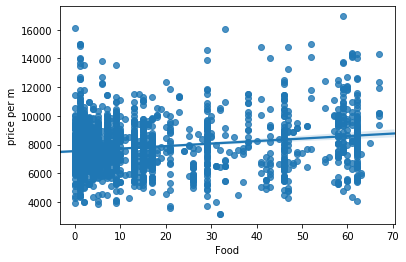

In [75]:
ax = sns.regplot(x="Food", y='price per m', data=df)

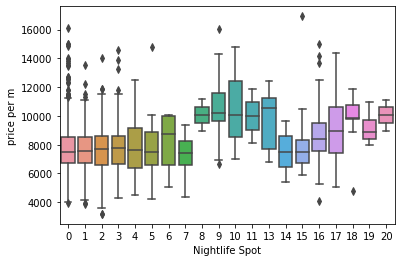

In [76]:
ax = sns.boxplot(x="Nightlife Spot", y='price per m', data=df)

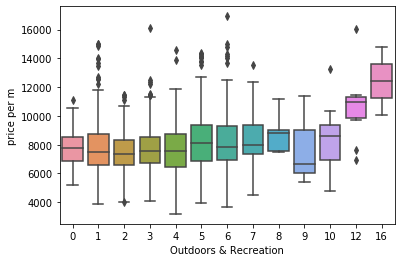

In [77]:
ax = sns.boxplot(x="Outdoors & Recreation", y='price per m', data=df)

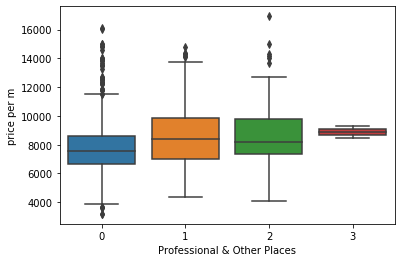

In [80]:
ax = sns.boxplot(x="Professional & Other Places", y='price per m', data=df)

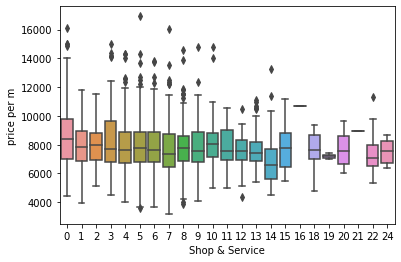

In [81]:
ax = sns.boxplot(x="Shop & Service", y='price per m', data=df)

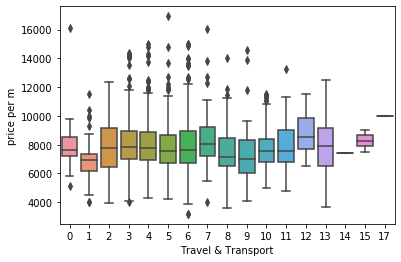

In [84]:
ax = sns.boxplot(x="Travel & Transport", y='price per m', data=df)

In [85]:
df.drop(["Shop & Service", "Travel & Transport"], axis = 1, inplace = True)

I'm going to use different types of regression models to predict prices of appartments based on data gathered in previous sections. I'll validate how well are they predicticg prices by using R2 score. \
To do this I'll split the data into:
- test and train sets - used to fine tune each model before validation
- validation set - used to compare models

Finally I'll use whole data set to predict apartment values with the best model and use difference between predicted value and appartment value as a filter for potentially good deals.

### Selecting X, y

In [86]:
X = df[['rooms', 'building_type', 'rent', 'built year', 'size',
       'floors', 'floor no', 'for_renovation', 'for_completion', 'distance',
       'Arts & Entertainment', 'College & University', 'Food',
       'Nightlife Spot', 'Outdoors & Recreation',
       'Professional & Other Places']]
y = df['price per m'].values

### Normalize data

In [87]:
from sklearn import preprocessing
X= preprocessing.StandardScaler().fit(X).transform(X)

### Split data into train test and validation data (to compare models)

In [88]:
from sklearn.model_selection import train_test_split
X_model, X_validate, y_model, y_validate = train_test_split( X, y, test_size=0.2, random_state=30)
X_train, X_test, y_train, y_test = train_test_split( X_model, y_model, test_size=0.2, random_state=30)

### K Nearest Neighbor(KNN)

In [89]:
from sklearn.neighbors import KNeighborsRegressor
Ks = 15
R2_score = np.zeros((Ks-1))
ConfustionMx = [];
for n in range(1,Ks):
    #Train Model and Predict  
    neigh = KNeighborsRegressor(n_neighbors = n).fit(X_train,y_train)
    yhat=neigh.predict(X_test)
    R2_score[n-1] = neigh.score(X_test, y_test)

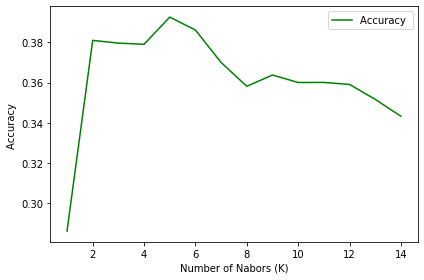

In [90]:
import matplotlib.pyplot as plt
plt.plot(range(1,Ks),R2_score,'g')
plt.legend(('Accuracy ', '+/- 3xstd'))
plt.ylabel('Accuracy ')
plt.xlabel('Number of Nabors (K)')
plt.tight_layout()
plt.show()

With k = 5 we are getting best results for KNeighbors.

In [91]:
knn = KNeighborsRegressor(n_neighbors = 5).fit(X_model,y_model)

## Decision Tree

In [96]:
from sklearn.tree import DecisionTreeRegressor 
maxDs = 20
R2_score = np.zeros((maxDs-1))
ConfustionMx = [];
for n in range(1,maxDs):
    #Train Model and Predict
    decisionTree = DecisionTreeRegressor(max_depth = n)
    decisionTree.fit(X_train,y_train)
    predTree = decisionTree.predict(X_test)
    R2_score[n-1] = decisionTree.score(X_test, y_test)

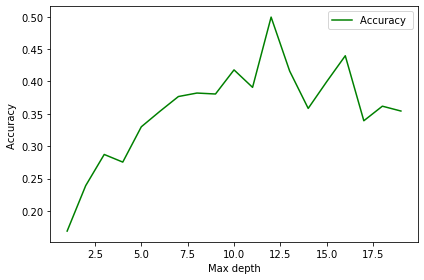

In [97]:
plt.plot(range(1,maxDs),R2_score,'g')
plt.legend(('Accuracy ', '+/- 3xstd'))
plt.ylabel('Accuracy ')
plt.xlabel('Max depth')
plt.tight_layout()
plt.show()

With max_depth = 7 we are getting best results for Decision Tree model, as with further increase of depth accuracy improves just a little.

In [109]:
decisionTree = DecisionTreeRegressor(max_depth = 7)
decisionTree.fit(X_model,y_model)

DecisionTreeRegressor(criterion='mse', max_depth=7, max_features=None,
                      max_leaf_nodes=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      presort=False, random_state=None, splitter='best')

### Support Vector Machine

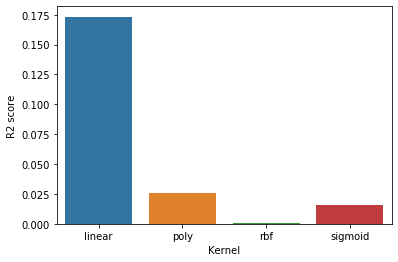

In [99]:
from sklearn import svm
kernels = ['linear', 'poly', 'rbf', 'sigmoid']
compare_svm = {"Kernel":[], "R2 score":[]}
for kernel in kernels:
    svm_model = svm.SVR(kernel=kernel, gamma='auto')
    svm_model.fit(X_train, y_train) 
    R2_score = svm_model.score(X_test, y_test)
    compare_svm["Kernel"].append(kernel)
    compare_svm["R2 score"].append(R2_score)
compare_svm_df = pd.DataFrame(compare_svm)
ax = sns.barplot(x="Kernel", y='R2 score', data=compare_svm_df)

In [100]:
svm_model = svm.SVR(kernel='linear', gamma='auto')
svm_model.fit(X_model, y_model)

SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='auto',
    kernel='linear', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

### Linear regression

In [101]:
from sklearn.linear_model import LinearRegression
reg = LinearRegression().fit(X_train, y_train)
R2_score = reg.score(X_test, y_test)
print("R2 score for linear regression is {}".format(R2_score))

R2 score for linear regression is 0.2768488095584761


In [102]:
lin_reg = LinearRegression().fit(X_model, y_model)
lin_reg.coef_

array([-215.40654466, -451.75468535,   17.01934878,  436.02544331,
       -409.34766905,  -91.16764693,   35.54109929, -322.29032616,
        -11.80070566,  -86.33608048,  194.04470355,  106.71737094,
        -29.98166163,  360.44376805,  117.33988611, -290.70275985])

### Validate each model

In [110]:
models_validation = {"Model":[], "R2 score":[]}

In [111]:
models_validation["Model"].append("KNN")
models_validation["R2 score"].append(knn.score(X_validate,y_validate))


In [112]:
models_validation["Model"].append("Decision Tree")
models_validation["R2 score"].append(decisionTree.score(X_validate,y_validate))

In [113]:
models_validation["Model"].append("SVM")
models_validation["R2 score"].append(svm_model.score(X_validate,y_validate))


In [114]:
models_validation["Model"].append("Linear Reg")
models_validation["R2 score"].append(lin_reg.score(X_validate,y_validate))

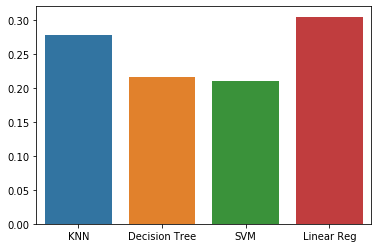

In [126]:
ax = sns.barplot(x="Model", y='R2 score', data=models_validation)

## Results section
where you discuss the results.

We can see that R2 score for models were rather low, but is the final result helpfull at all? \
Maybe a simpler alternative could be just to review only the cheapest listings? \
Lets compare a list of Top 200 listings provided by the model with the list of 200 listings with lowest prices.

## Predicting values of appartments based on Linear regression

In [116]:
y_hat = lin_reg.predict(X)

add it to DataFrame

In [117]:
df["y_hat"] = y_hat

list 10 mostly underpriced appartments based on the model - with greatest % difference between y_hat and the real price.

In [118]:
df["delta"] = round((df["y_hat"]-df["price per m"])/df["price per m"]*100, 2)

In [119]:
result = df.sort_values(by=["delta"], ascending=False).head(20)

In [120]:
for price, url in zip(result["price per m"][:10], result["url"][:10]):
    print("Price {}PLN per m, url {}".format(price, url))

Price 3186PLN per m, url https://www.otodom.pl/oferta/udzialy-w-kamienicy-ID465zE.html#d9c7861cb1
Price 3186PLN per m, url https://www.otodom.pl/oferta/udzial-w-kamienicy-ID465zW.html#d9c7861cb1
Price 3614PLN per m, url https://www.otodom.pl/oferta/3-pokojowe-mieszkanie-blisko-centrum-66m2-roi-6-8-ID43R6X.html#8c74f89272
Price 4061PLN per m, url https://www.otodom.pl/oferta/ogrody-polska-blisko-centrum-przestronny-ogrod-ID46bH3.html#c0414dace4
Price 4757PLN per m, url https://www.otodom.pl/oferta/mieszkanie-na-inwestycje-w-centrum-poznania-ID4109i.html#bc034ebf07
Price 3989PLN per m, url https://www.otodom.pl/oferta/jezyce-3-pokoje-przestronne-ID467cO.html#0dbf6fa631
Price 4156PLN per m, url https://www.otodom.pl/oferta/nowe-mieszkanie-na-wildzie-2-z-panorama-miasta-ID42Dws.html#5e6b54dcf2
Price 3959PLN per m, url https://www.otodom.pl/oferta/idealna-oferta-dla-inwestora-ID3Mldm.html#6e0bbbb483
Price 3860PLN per m, url https://www.otodom.pl/oferta/mieszkanie-57-m-poznan-ID44GEs.html#44

### compare a list of Top 200 listings provided by the model with the list of 200 listings with lowest prices

In [121]:
evaluate_count = 200
model_result = df.sort_values(by=["delta"], ascending=False).head(evaluate_count)
model_result = model_result.sort_values(by=["price per m"], ascending=True)
lowest_prices = df.sort_values(by=["price per m"], ascending=True).head(evaluate_count)

In [122]:
model_ids = list(model_result["id"].values)
lowest_price_ids = list(lowest_prices["id"].values)
full_id_list = model_ids + lowest_price_ids
full_id_list = list(dict.fromkeys(full_id_list))
print(len(full_id_list))

283


In [123]:
print_comparison = {"id":[], "inModel":[], "inLowestPrice":[]}

for unique_id in full_id_list:
    print_comparison["id"].append(unique_id)
    print_comparison["inModel"].append(1 if unique_id in model_ids else 0)
    print_comparison["inLowestPrice"].append(1 if unique_id in lowest_price_ids else 0)

comparison_df = pd.DataFrame(print_comparison)
comparison_df['both'] = comparison_df["inModel"]*comparison_df["inLowestPrice"]
comparison_df.sort_values(by=["inModel", "inLowestPrice"], ascending=False, inplace=True)
comparison_df.reset_index(drop=True, inplace=True)
comparison_df[["inModel", "inLowestPrice", 'both']].agg(['sum'])

,inModel,inLowestPrice,both
sum,200,200,117


40% of appartments proposed by the model would not have been suggesed by simply selecting the lowest price.

### Lets see how did differences in prices look like.

In [124]:
mean_price_in_the_city = int(df["price per m"].agg(['mean'])["mean"])
mean_price_range = [mean_price_in_the_city]*evaluate_count
x = range(1,evaluate_count+1)

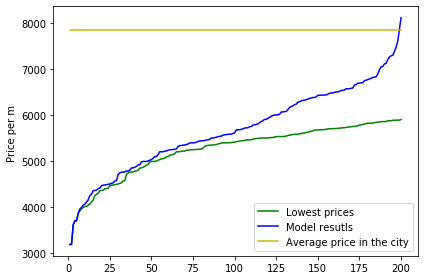

In [125]:
plt.plot(x,lowest_prices["price per m"].values,'g')
plt.plot(x,model_result["price per m"].values,'b')
plt.plot(x, mean_price_range,'y')
plt.legend(('Lowest prices', 'Model resutls', 'Average price in the city'))
plt.ylabel('Price per m ')
plt.tight_layout()
plt.show()

We can see that model is more liekly to suggest listings with prices closer to average price in the city.

## Discussion section
where you discuss any observations you noted and any recommendations you can make based on the results.

Based on the results of the project we can see that there is a lot o information impacting the price but missing in the data. Unfortunately I was not able to parse this information because it was either unavailable at all or could be inferred from picture or descriptions only.

More information could be added like: standard of the apartment, building condition, how well rooms are arranged. Missing data which were replaced during preparation could be filled in.

Both of the above would have to be done manually but this should improve results of models.

In future an ability to add data incrementally about new listings and venues would be a plus as this project was based only on active listings. My hope is that with more historical data, we could get better predictions. 

## Conclusion section
where you conclude the report.

Based on Linear Regression Model and Foursquare, geo and real estate data, I was able to identify potential good deals in a price range closer to average price of an apartment in the city. This can be considered as satisfactory result as such infromation is not available when filtering only by lowest price. 

Consider that the goal of this project was to suggest potential good deals, but making the final decision on purchase consists of more criteria that need to be evaluated.